In [1]:
import numpy as np
from numpy.linalg import norm, solve, det
from numpy.random import default_rng
from numpy.random import randn
from numpy import log, exp, zeros, eye, pi, array, diag, ones, errstate, r_
from scipy.stats import multivariate_normal as MVN
from scipy.stats import norm as ndist
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from mici.samplers import ChainState
from mici.systems import DenseConstrainedEuclideanMetricSystem as DCEMS
from mici.systems import EuclideanMetricSystem as EMS
from mici.integrators import ConstrainedLeapfrogIntegrator as CLI
from mici.integrators import LeapfrogIntegrator as LI
from mici.samplers import DynamicMultinomialHMC as DMHMC
from mici.samplers import StaticMetropolisHMC as SMHMC

from tangential_hug_functions import Hug, HugTangential
from utils import ESS_univariate, prep_contour
import time

In [2]:
from autograd import grad, jacobian
import autograd.numpy as anp 
from autograd.numpy.linalg import det as adet
from autograd.numpy.linalg import solve as asolve
from autograd.numpy.linalg import norm as anorm
from autograd.scipy.stats import multivariate_normal as aMVN
import autograd.scipy as asp
from autograd.numpy import log as alog

import arviz
from arviz import rhat

In [3]:
# σ = 1e-8
# y = 1.0
# N = 2000
# B = 20
# δ_CHMC = 0.2
# δ_THUG = δ_CHMC
# δ_HUG  = δ_THUG
# δ_HMC  = δ_CHMC

In [4]:
# # C-HMC
# N_CHMC = 2000  # Number of samples for C-HMC
# δ_CHMC = 0.3   # Step-size for C-HMC
# n_CHMC = 20     # Number of integrator steps to simulate in each transition 
# T_CHMC = δ_CHMC * n_CHMC

# ### HUG
# ϵ_HUG = 0.001
# δ_HUG = δ_CHMC #0.1 # δ_CHMC
# N_HUG = N_CHMC
# B_HUG = n_CHMC
# T_HUG = δ_HUG * B_HUG

# ### THUG
# ϵ_THUG = ϵ_HUG
# N_THUG = N_HUG
# δ_THUG = δ_CHMC #δ_HUG # δ_CHMC
# B_THUG = B_HUG
# T_THUG = δ_THUG * B_HUG


# ### HMC
# ϵ_HMC = ϵ_HUG
# n_HMC = n_CHMC
# δ_HMC = δ_CHMC #0.0003 #δ_CHMC
# T_HMC = δ_HMC * n_HMC
# N_HMC = N_CHMC
# # print('Integration time:')
# # print('C-HMC: {}'.format(T_CHMC))
# # print('HUG  : {}'.format(T_HUG))
# # print('THUG:  {}'.format(T_THUG))
# # print('HMC:   {}'.format(T_HMC))

# # print('Integration steps:')
# # print('C-HMC: {}'.format(n_CHMC))
# # print('HUG  : {}'.format(B_HUG))
# # print('THUG:  {}'.format(B_THUG))
# # print('HMC:   {}'.format(n_HMC))

# # print('Step Size:')
# # print('C-HMC: {}'.format(δ_CHMC))
# # print('HUG  : {}'.format(δ_HUG))
# # print('THUG:  {}'.format(δ_THUG))
# # print('HMC:   {}'.format(δ_HMC))

# # print('Epsilon Tolerance:')
# # print('HUG  : {}'.format(ϵ_HUG))
# # print('THUG:  {}'.format(ϵ_THUG))
# # print('HMC:   {}'.format(ϵ_HMC))

- Log prior
$$
\log p(\xi) = -\frac{3}{2}\log(2\pi) - \frac{1}{2}\xi^\top\xi
$$
- Gradient of Log Prior
$$
\nabla_\xi \log p(\xi) = -\xi
$$
- Constraint function
$$
f(\xi) = \xi_1^2 + 3\xi_0^2(\xi_0^2 - 1) + \sigma\xi_2
$$
- Gradient of constraint function
$$
\nabla_\xi f(\xi) = (12\xi_0^3 - 6\xi_0, 2\xi_1, \sigma)^\top\qquad \in\mathbb{R}^{3\times 1}
$$
- Jacobian of constraint function
$$
J_f(\xi) = (12\xi_0^3 - 6\xi_0, 2\xi_1, \sigma) \qquad \in\mathbb{R}^{1\times 3}
$$
- Gram Jacobian matrix of constraint function
$$
J_f(\xi) J_f(\xi)^\top = \|\nabla_\xi f(\xi)\|^2 = 144\xi_0^6 + 36\xi_0^2 - 72\xi_0^4 + 4\xi_1^2 + \sigma^2
$$
- Hessian of Constraint function
$$
\nabla_\xi^2 f(\xi) = \begin{pmatrix}
    36\xi_0^2 - 6 & 0 & 0 \\
    0             & 2 & 0 \\
    0             & 0 & 0
\end{pmatrix}
$$
- Posterior density
$$
p(\xi\mid y)\propto p(\xi) |\det J_f(\xi) J_f(\xi)^\top|^{-1/2}
$$
- Log Posterior Density
$$
\log p(\xi\mid y)\propto - \frac{1}{2}\xi^\top\xi -\log \|\nabla_\xi f(\xi)\| = - \frac{1}{2}\xi^\top\xi -\frac{1}{2}\log \|\nabla_\xi f(\xi)\|^2
$$
- Negative log posterior density
$$
-\log p(\xi\mid y)\propto \frac{1}{2}\xi^\top\xi + \log \|\nabla_\xi f(\xi)\| = \frac{1}{2}\xi^\top\xi + \frac{1}{2}\log \|\nabla_\xi f(\xi)\|^2
$$

- Gradient of Gram Jacobian Matrix
$$
\nabla_\xi \|\nabla_\xi f(\xi)\|^2 = \begin{pmatrix}
    864\xi_0^5 + 72\xi_0 - 288\xi_0^3 \\
    8\xi_1 \\
    0
\end{pmatrix}
$$
- Gradient Negative Log Posterior Density
$$
-\nabla_\xi \log p(\xi\mid y) \propto \xi + \frac{\nabla_\xi \|\nabla_\xi f(\xi)\|}{\|\nabla_\xi f(\xi)\|^2}
$$

In [40]:
def construct_functions(y, σ, ϵ):
    FUNCTIONS = {}
    FUNCTIONS['log_prior_theta'] = lambda θ: aMVN.logpdf(θ, mean=zeros(2), cov=eye(2))
    FUNCTIONS['logprior']      = lambda ξ: aMVN.logpdf(ξ, mean=zeros(3), cov=eye(3))  # Prior over (θ, υ) is N(0, I).
    FUNCTIONS['grad_logprior'] = grad(FUNCTIONS['logprior'])
    FUNCTIONS['fwd_func']      = lambda θ: anp.array([θ[1]**2 + 3.0*(θ[0]**2)*(θ[0]**2 - 1)])
    FUNCTIONS['fwd_constr']    = lambda θ: FUNCTIONS['fwd_func'](θ) - y
    FUNCTIONS['fwd_jacob']     = jacobian(FUNCTIONS['fwd_constr'])
    FUNCTIONS['fwd_grad']      = lambda θ: FUNCTIONS['fwd_jacob'](θ).flatten()
    FUNCTIONS['constr']        = lambda ξ: anp.array([ξ[1]**2 + 3.0*(ξ[0]**2)*(ξ[0]**2 - 1) + σ*ξ[2]]) - y
    FUNCTIONS['jacob_constr']  = jacobian(FUNCTIONS['constr']) 
    FUNCTIONS['grad_constr']   = lambda ξ: FUNCTIONS['jacob_constr'](ξ).flatten()
    FUNCTIONS['neg_log_dens']  = lambda ξ: -FUNCTIONS['logprior'](ξ) + 0.5*alog(anorm(FUNCTIONS['jacob_constr'](ξ)@FUNCTIONS['jacob_constr'](ξ).T))
    FUNCTIONS['grad_neg_log_dens']               = grad(FUNCTIONS['neg_log_dens'])
    FUNCTIONS['log_approximate_lifted']          = lambda ξ: FUNCTIONS['logprior'](ξ) - (FUNCTIONS['constr'](ξ)**2) / (2*(ϵ**2))
    FUNCTIONS['neg_log_approximate_lifted']      = lambda ξ: -FUNCTIONS['log_approximate_lifted'](ξ)
    FUNCTIONS['grad_neg_log_approximate_lifted'] = grad(FUNCTIONS['neg_log_approximate_lifted'])
    # Function to find point on manifold
    def find_point_on_lifted_manifold(υ_max=5, max_iter=200):
        iteration = 0
        while iteration <= max_iter:
            θ = anp.random.normal(size=2)
            υ = (- FUNCTIONS['constr'](anp.array([*θ, 0.0])))[0] / σ
            if abs(υ) < υ_max:
                return anp.array([*θ, υ])
    # Trace function for HMC and C-HMC
    def trace_func(state):
        x, y, z = state.pos
        return {'x': x, 'y': y, 'z': z}
    FUNCTIONS['find_point_on_lifted_manifold'] = find_point_on_lifted_manifold
    FUNCTIONS['trace_func'] = trace_func
    FUNCTIONS['trace_func_θ'] = lambda state: {'x': state.pos[0], 'y': state.pos[1]}
    # True log posterior (over theta only)
    #FUNCTIONS['log_posterior'] = lambda θ: FUNCTIONS['log_prior_theta'](θ) - (anorm(FUNCTIONS['fwd_constr'](θ))**2) / (2*(σ**2))
    FUNCTIONS['log_posterior'] = lambda θ: FUNCTIONS['log_prior_theta'](θ) - (FUNCTIONS['fwd_constr'](θ)@FUNCTIONS['fwd_constr'](θ))/(2*σ**2)
    FUNCTIONS['neg_log_posterior'] = lambda θ: - FUNCTIONS['log_posterior'](θ)
    FUNCTIONS['grad_neg_log_posterior'] = grad(FUNCTIONS['neg_log_posterior'])
    # Function to find point on the F(θ) = y manifold
    FUNCTIONS['find_θ_giving_y'] = lambda: fsolve(lambda θ: r_[FUNCTIONS['fwd_constr'](θ), 0], randn(2))
    return FUNCTIONS


In [6]:
# F = construct_functions(1.0, 0.02, 0.01)

In [6]:
# logprior       = lambda ξ: aMVN.logpdf(ξ, mean=zeros(3), cov=eye(3))
# grad_logprior  = grad(logprior)
# constr         = lambda ξ: anp.array([ξ[1]**2 + 3.0*(ξ[0]**2)*(ξ[0]**2 - 1) + σ*ξ[2]]) - y
# jacob_constr   = jacobian(constr) 
# neg_log_dens    = lambda ξ: - logprior(ξ) + 0.5*anp.log(anorm(jacob_constr(ξ)@jacob_constr(ξ).T))#+ anp.log(anorm(anp.array([12.0*ξ[0]**3 - 6.0*ξ[0], 2.0*ξ[1], σ])))
# grad_neg_log_dens = grad(neg_log_dens)

# def find_point_on_lifted_manifold(υ_max=5, max_iter=200):
#     iteration = 0
#     while iteration <= max_iter:
#         θ = anp.random.normal(size=2)
#         #υ = (y - (θ[1]**2 + 3.0*(θ[0]**2)*(θ[0]**2 - 1))) / σ
#         υ = (- constr(anp.array([*θ, 0.0])))[0] / σ
#         if abs(υ) < υ_max:
#             return anp.array([*θ, υ])
#         else:
#             continue

# def log_approximate_lifted(ξ):
#     return logprior(ξ) - (constr(ξ)**2) / (2*(ϵ_HMC**2))

# neg_log_approximate_lifted = lambda ξ: - log_approximate_lifted(ξ)
# grad_neg_log_approximate_lifted = grad(neg_log_approximate_lifted)

In [7]:
### Functions for C-HMC
# logprior      = lambda ξ: MVN(zeros(3), eye(3)).logpdf(ξ)
# grad_logprior = lambda ξ: -ξ
# constr        = lambda ξ: array([ξ[1]**2 + 3*(ξ[0]**2)*(ξ[0]**2 - 1) + σ*ξ[2]]) - y
# jacob_constr  = lambda ξ: array([[12*ξ[0]**3 - 6*ξ[0], 2*ξ[1], σ]])
# neg_log_dens  = lambda ξ: 0.5*(ξ@ξ) + log(norm(array([12*ξ[0]**3 - 6*ξ[0], 2*ξ[1], σ])))

# def grad_neg_log_density(ξ):
#     denominator = norm(array([12*ξ[0]**3 - 6*ξ[0], 2*ξ[1], σ]))**2
#     numerator   = array([864*ξ[0]**5 + 72*ξ[0] - 288*ξ[0]**3, 8*ξ[1], 0])
#     return ξ + numerator / denominator



# h  = lambda θ: θ[1]**2 + 3*(θ[0]**2)*(θ[0]**2 - 1)
# fσ = lambda ξ: h(ξ[:2]) + σ*ξ[2]

# def find_point_on_lifted_manifold():
#     θ = MVN(zeros(2), eye(2)).rvs()
#     η = (y - (θ[1]**2 + 3*(θ[0]**2)*(θ[0]**2 - 1))) / σ
#     return np.array([*θ, η])

In [7]:
def run_chmc(δ, n_step, N, F, ξ0=None, display=True, return_init=False):
    """Runs C-HMC. n_step is the number of leapfrog steps."""
    system          = DCEMS(F['neg_log_dens'], F['constr'], jacob_constr=F['jacob_constr'], grad_neg_log_dens=F['grad_neg_log_dens'])
    integrator      = CLI(system, step_size=δ)
    sampler         = SMHMC(system, integrator, default_rng(seed=1234), n_step=n_step)
    if ξ0 is None:
        init_state      = F['find_point_on_lifted_manifold']()
    else:
        init_state = ξ0
    init_state_CHMC = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
    start_time = time.time()
    final_state, trace, stat = sampler.sample_chain(n_iter=N, init_state=init_state_CHMC, trace_funcs=[F['trace_func']], display_progress=display)
    run_time = time.time() - start_time
    if return_init:
        return final_state, trace, stat, run_time, init_state
    else:
        return final_state, trace, stat, run_time

In [8]:
# final_CHMC, trace_CHMC, stat_CHMC, time_CHMC, init_CHMC = run_chmc(δ=0.1, n_step=5, N=1000, F=F, display=False, return_init=True)

In [48]:
# system          = DCEMS(neg_log_dens, constr, jacob_constr=jacob_constr, grad_neg_log_dens=grad_neg_log_dens)
# integrator      = CLI(system, step_size=δ_CHMC)
# sampler         = SMHMC(system, integrator, default_rng(seed=1234), n_step=n_CHMC)
# init_state      = find_point_on_lifted_manifold(υ_max=100)
# init_state_CHMC = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
# final_state, trace, stat = sampler.sample_chain(n_iter=N_CHMC, init_state=init_state_CHMC, trace_funcs=[trace_func])

### Standard HMC on approximate lifted distribution (gaussian kernel)

Try using a Gaussian kernel
$$
k_\epsilon(u) = \frac{1}{\sqrt{2\pi}\epsilon}\exp\left(-\frac{1}{2}\frac{u^2}{\epsilon^2}\right)
$$
where $u = \|f_\sigma(\xi) - y\| = |f_\sigma(\xi) - y|$ 
The prior is still
$$
logp(\xi) = log N(\xi\mid 0, I) = -\frac{3}{2}\log (2\pi) - \frac{1}{2}\xi^\top\xi
$$
The posterior the is
$$
\log p_\epsilon(\xi\mid y) \propto -\frac{1}{2}\xi^\top\xi -\frac{(f_\sigma(\xi) - y)^2}{2\epsilon^2}
$$
It's gradient is
$$
\nabla_\xi \log p_\epsilon(\xi\mid y) \propto -\xi - \left(\frac{f_\sigma(\xi) - y}{\epsilon^2}\right)\nabla_\xi f_\sigma(\xi)
$$

In [49]:
# def initial_point_lifted(n_tries=10000):
#     for i in range(n_tries):
#         # Sample from prior (ish)
#         θ = MVN(zeros(2), eye(2)).rvs()
#         η = randn() * σ
#         ξ = np.array([*θ, η])
#         if exp(log_approximate_lifted(ξ)) > 1e-5:
#             return ξ
#     print('Not found')
#     return None

In [50]:
# def log_approximate_lifted(ξ):
#     return -0.5*(ξ@ξ) - (constr(ξ)**2) / (2*(ϵ_HMC**2))

# def neg_log_approximate_lifted(ξ):
#     return 0.5*(ξ@ξ) + (constr(ξ)**2) / (2*(ϵ_HMC**2))

# def grad_neg_log_approximate_lifted(ξ):
#     return ξ + (constr(ξ) / (ϵ_HUG**2)) * jacob_constr(ξ).flatten()

# from autograd import grad as grad_autograd
# grad_neg_log_approximate_lifted = grad_autograd(neg_log_approximate_lifted)

In [51]:
# init_state_lifted_gauss      = init_state #initial_point_lifted()

In [9]:
def run_hmc_approx_lifted(δ, n_step, N, F, init_state, target='neg_log_approximate_lifted', display=True):
    assert target in ['neg_log_approximate_lifted', 'neg_log_posterior']
    if target == 'neg_log_approximate_lifted':
        grad_key = 'grad_neg_log_approximate_lifted'
        trace_key = 'trace_func'
    else: 
        grad_key = 'grad_neg_log_posterior'
        init_state = F['find_θ_giving_y']()
        trace_key = 'trace_func_θ'
    system                   = EMS(F[target], grad_neg_log_dens=F[grad_key])
    integrator               = LI(system, step_size=δ)
    sampler                  = SMHMC(system, integrator, default_rng(seed=1234), n_step=n_step)
    init_state               = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
    start_time               = time.time()
    final_state, trace, stat = sampler.sample_chain(n_iter=N, init_state=init_state, trace_funcs=[F[trace_key]], display_progress=display)
    run_time                 = time.time() - start_time
    return final_state, trace, stat, run_time

In [10]:
# final_HMC, trace_HMC, stat_HMC, time_HMC = run_hmc_approx_lifted(δ=0.1, n_step=5, N=1000, F=F, init_state=init_CHMC, target='neg_log_posterior', display=False)

In [209]:
# system_HMC                   = EMS(neg_log_approximate_lifted, grad_neg_log_dens=grad_neg_log_approximate_lifted)
# integrator_HMC               = LI(system_HMC, step_size=δ_HMC)
# sampler_HMC                  = SMHMC(system_HMC, integrator_HMC, default_rng(seed=1234), n_step=n_HMC)
# init_state_HMC               = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
# final_HMC, trace_HMC, stat_HMC = sampler_HMC.sample_chain(n_iter=N_HMC, init_state=init_state_HMC, trace_funcs=[trace_func])

In [210]:
# HMC_stats           = {key[0].split('.', 1)[1]: value for (key, value) in final_HMC._call_counts.items()}
# n_grad_log_dens_HMC = HMC_stats['grad_neg_log_dens']
# n_neg_log_dens_HMC  = HMC_stats['neg_log_dens']
# samples_HMC         = np.vstack((trace_HMC['x'], trace_HMC['y'], trace_HMC['z'])).T
# dens_values_HMC     = -np.apply_along_axis(neg_log_approximate_lifted, 1, samples_HMC)
# logpiESS_HMC        = ESS_univariate(dens_values_HMC)[0]
# minESS_HMC          = min(ESS_univariate(samples_HMC))

### Hug and Thug

In [11]:
def run_thug(T, B, N, α, F, init, target='log_approximate_lifted'):
    assert target in ['log_approximate_lifted', 'log_posterior']
    if target == 'log_approximate_lifted':
        q = MVN(zeros(3), eye(3))
        grad_key = 'grad_constr'
    else:
        q = MVN(zeros(2), eye(2))
        grad_key = 'fwd_grad'
        init = F['find_θ_giving_y']()
    start_time = time.time()
    samples, acc = HugTangential(init, T, B, N, α, q, F[target], F[grad_key])
    run_time = time.time() - start_time
    return samples, acc, run_time

In [12]:
# hug_samples, acceptance_hug, time_hug = run_thug(B*δ_HUG, B, N, 0.0, F, init_CHMC)

In [13]:
# thug_samples, acceptance_thug, time_thug = run_thug(B*δ_THUG, B, N, 0.99, F, init_CHMC)

In [214]:
# ALPHA = 0.99

In [62]:
# #### Functions for HUG
# q = MVN(zeros(3), eye(3))

# # def log_epanechnikov_kernel(ξ, ϵ):
# #     u = norm(constr(ξ))
# #     with np.errstate(divide='ignore'):
# #         return log((3*(1 - (u**2 / (ϵ**2))) / (4*ϵ)) * float(u <= ϵ))

# # def indicator_kernel(ξ, ϵ):
# #     with errstate(divide='ignore'):
# #         return log(float(abs(constr(ξ)[0]) <= ϵ))

# # logpi_HUG = lambda ξ: logprior(ξ) + log_epanechnikov_kernel(ξ, ϵ_HUG)
# # logpi_HUG = lambda ξ: logprior(ξ) + indicator_kernel(ξ, ϵ_HUG)
# # logpi_HUG = lambda ξ: log_approximate_lifted(ξ)
# grad_HUG  = lambda ξ: jacob_constr(ξ).flatten()


# ### Functions for THUG
# # logpi_THUG = lambda ξ: logprior(ξ) + log_epanechnikov_kernel(ξ, ϵ_THUG)
# # logpi_THUG = lambda ξ: log_approximate_lifted(ξ)
# # logpi_THUG = lambda ξ: logprior(ξ) + indicator_kernel(ξ, ϵ_THUG)
# grad_THUG  = lambda ξ: jacob_constr(ξ).flatten()

# hug_samples, acceptance_hug = Hug(init_state, T_HUG, B_HUG, N_HUG, q, log_approximate_lifted, grad_HUG)
# thug_samples, acceptance_thug = HugTangential(init_state, T_THUG, B_THUG, N_THUG, ALPHA, q, log_approximate_lifted, grad_THUG)

### Results

In [15]:
# rmse = lambda x: np.sqrt(np.mean(x**2))


# ### Computations for CHMC
# CHMC_stats           = {key[0].split('.', 1)[1]: value for (key, value) in final_state._call_counts.items()}
# n_constr_eval_CHMC   = CHMC_stats['constr']
# n_jac_constr_CHMC    = CHMC_stats['jacob_constr']
# n_grad_log_dens_CHMC = CHMC_stats['grad_neg_log_dens']
# samples_CHMC         = np.vstack((trace['x'], trace['y'], trace['z'])).T
# n_constr_and_jacob_CHMC = n_constr_eval_CHMC + n_jac_constr_CHMC


# log_dens_values_CHMC     = -np.apply_along_axis(neg_log_dens, 1, samples_CHMC)
# logpiESS_CHMC            = ESS_univariate(log_dens_values_CHMC)
# minESS_CHMC              = min(ESS_univariate(samples_CHMC))
# constr_per_ess_chmc      = n_constr_eval_CHMC / logpiESS_CHMC
# c_and_j_per_ess_chmc     = (n_constr_eval_CHMC + n_jac_constr_CHMC) / logpiESS_CHMC
# rmse_CHMC                = rmse(np.apply_along_axis(constr, 1, samples_CHMC) - y)

# ### Computations for HUG
# log_dens_values_HUG     = np.apply_along_axis(logpi_HUG, 1, hug_samples)
# logpiESS_HUG            = ESS_univariate(log_dens_values_HUG)[0]
# minESS_HUG              = min(ESS_univariate(hug_samples))
# n_constr_eval_HUG       = N_HUG + 1
# n_jacob_constr_HUG      = B_HUG * N_HUG
# eval_per_ess_hug        = n_constr_eval_HUG / logpiESS_HUG
# c_and_j_per_ess_hug     = (n_constr_eval_HUG + n_jacob_constr_HUG) / logpiESS_HUG
# rmse_HUG                = rmse(np.apply_along_axis(constr, 1, hug_samples) - y)
# n_constr_and_jacob_HUG  = n_constr_eval_HUG + n_jacob_constr_HUG

# ### Computations for THUG
# log_dens_values_THUG     = np.apply_along_axis(logpi_THUG, 1, thug_samples)
# logpiESS_THUG            = ESS_univariate(log_dens_values_THUG)[0]
# minESS_THUG              = min(ESS_univariate(thug_samples))
# n_constr_eval_THUG       = N_THUG + 1
# n_jacob_constr_THUG      = 1 + (B_THUG + 1) * N_THUG
# eval_per_ess_thug        = n_constr_eval_THUG / logpiESS_THUG
# c_and_j_per_ess_thug     = (n_constr_eval_THUG + n_jacob_constr_THUG) / logpiESS_THUG
# rmse_THUG                = rmse(np.apply_along_axis(constr, 1, thug_samples) - y)
# n_constr_and_jacob_THUG  = n_constr_eval_THUG + n_jacob_constr_THUG

In [65]:
n_constr_hug  = lambda B, N: N + 1
n_jac_hug     = lambda B, N: B*N
n_constr_thug = lambda B, N: N + 1
n_jac_thug    = lambda B, N: 1 + (B + 1)*N

def compute_metrics_thug_approx_lifted(samples, log_approximate_lifted, n_constr, n_jac, acceptance, time):
    metrics = {}
    log_dens_values                            = np.apply_along_axis(log_approximate_lifted, 1, samples)
    metrics['log_dens_ESS']                    = ESS_univariate(log_dens_values.flatten())
    metrics['minESS']                          = min(ESS_univariate(samples))
    metrics['n_constr_and_jac_per_minESS']     = (n_constr + n_jac) / metrics['minESS']
    metrics['n_constr_and_jac_per_logdensESS'] = (n_constr + n_jac) / metrics['log_dens_ESS'] 
    metrics['ap']                              = acceptance.mean()*100
    metrics['time']                            = time
    metrics['minESS_per_walltime']             = metrics['minESS'] / metrics['time']
    metrics['logdensESS_per_walltime']         = metrics['log_dens_ESS'] / metrics['time']
    return metrics

def compute_metrics_mici(final_state, trace, neg_log_dens, stat_mici, time):
    metrics = {}
    stats    = {key[0].split('.', 1)[1]: value for (key, value) in final_state._call_counts.items()}
    try:
        samples  = np.vstack((trace['x'], trace['y'], trace['z'])).T
    except KeyError:
        samples  = np.vstack((trace['x'], trace['y'])).T
    n_constr = stats['constr'] if 'constr' in stats.keys() else 0.0
    n_jac_constr = stats['jacob_constr'] if 'jacob_constr' in stats.keys() else 0.0
    n_neg_log_dens = stats['neg_log_dens']
    n_grad_neg_log_dens = stats['grad_neg_log_dens']
    log_dens_values = -np.apply_along_axis(neg_log_dens, 1, samples)
    metrics['log_dens_ESS'] = ESS_univariate(log_dens_values.flatten())
    metrics['minESS'] = min(ESS_univariate(samples))
    metrics['minESS_thetaonly'] = min(ESS_univariate(samples[:, :2]))
    # Metrics per minESS
    metrics['n_constr_and_jac_per_minESS'] = (n_constr + n_jac_constr) / metrics['minESS']
    metrics['n_constr_and_jac_and_grad_per_minESS'] = (n_constr + n_jac_constr + n_grad_neg_log_dens) / metrics['minESS']
    metrics['n_constr_and_jac_and_grad_and_nld_per_minESS'] = (n_constr + n_jac_constr + n_grad_neg_log_dens + n_neg_log_dens) / metrics['minESS']
    # Metrics per logpiESS
    metrics['n_constr_and_jac_per_logdensESS'] = (n_constr + n_jac_constr) / metrics['log_dens_ESS']
    metrics['n_constr_and_jac_and_grad_per_logdensESS'] = (n_constr + n_jac_constr + n_grad_neg_log_dens) / metrics['log_dens_ESS']
    metrics['n_constr_and_jac_and_grad_and_nld_per_logdensESS'] = (n_constr + n_jac_constr + n_grad_neg_log_dens + n_neg_log_dens) / metrics['log_dens_ESS']
    # Acceptance probability
    metrics['ap'] = stat_mici['accept_stat'].mean()*100
    metrics['time'] = time
    metrics['minESS_per_walltime']             = metrics['minESS'] / metrics['time']
    metrics['logdensESS_per_walltime']         = metrics['log_dens_ESS'] / metrics['time']
    metrics['minESS_theta_only_per_walltime']  = metrics['minESS_thetaonly'] / metrics['time']
    return metrics

In [230]:
# metrics_hug  = compute_metrics_thug_approx_lifted(hug_samples, F['log_approximate_lifted'], n_constr_hug(), n_jac_hug(), acceptance_hug, time_hug)
# metrics_thug = compute_metrics_thug_approx_lifted(thug_samples, F['log_approximate_lifted'], n_constr_thug(), n_jac_thug(), acceptance_thug, time_thug)
# metrics_hmc  = compute_metrics_mici(final_HMC, trace_HMC, F['neg_log_approximate_lifted'], stat_HMC, time_HMC)
# metrics_chmc = compute_metrics_mici(final_CHMC, trace_CHMC, F['neg_log_dens'], stat_CHMC, time_CHMC)

In [23]:
# AP_HUG  = acceptance_hug.mean() * 100
# AP_THUG = acceptance_thug.mean() * 100
# AP_CHMC = stat['accept_stat'].mean() * 100
# AP_HMC  = stat_HMC['accept_stat'].mean() * 100

# print("Mean Acceptance Probability HUG:  {:.3}".format(AP_HUG))
# print("Mean Acceptance Probability THUG: {:.3}".format(AP_THUG))
# print("Mean Acceptance Probability CHMC: {:.3}".format(AP_CHMC))
# print("Mean Acceptance Probability HMC:  {:.3}".format(AP_HMC))

In [22]:
# print("HUG:  ", n_constr_eval_HUG)
# print("THUG: ", n_constr_eval_THUG)
# print("CHMC: ", n_constr_eval_CHMC)
# print("HMC:  ", n_neg_log_dens_HMC)

In [24]:
# print("HUG:  ", n_jacob_constr_HUG)
# print("THUG: ", n_jacob_constr_THUG)
# print("CHMC: ", n_jac_constr_CHMC)
# print("HMC:  ", n_grad_log_dens_HMC)

In [25]:
# print("HUG:  ", n_constr_eval_HUG + n_jacob_constr_HUG)
# print("THUG: ", n_constr_eval_THUG + n_jacob_constr_THUG)
# print("CHMC: ", n_constr_eval_CHMC + n_jac_constr_CHMC)
# print("HMC:  ", n_neg_log_dens_HMC + n_grad_log_dens_HMC)

In [26]:
# print('ESS HUG:  ', logpiESS_HUG)
# print('ESS THUG: ', logpiESS_THUG)
# print('ESS HMC:  ', logpiESS_HMC)
# print('ESS CHMC: ', logpiESS_CHMC)

In [27]:
# print('minESS HUG:  ', minESS_HUG)
# print('minESS THUG: ', minESS_THUG)
# print('minESS HMC:  ', minESS_HMC)
# print('minESS CHMC: ', minESS_CHMC)

In [28]:
# MIN_ESS = True
# if MIN_ESS:
#     ESS_CHMC = minESS_CHMC
#     ESS_HMC  = minESS_HMC
#     ESS_THUG = minESS_THUG
#     ESS_HUG  = minESS_HUG
# else:
#     ESS_CHMC = logpiESS_CHMC
#     ESS_HMC  = logpiESS_HMC[0]
#     ESS_THUG = logpiESS_THUG[0]
#     ESS_HUG  = logpiESS_HUG[0]

In [29]:
# print("--- Constraint ---")
# print("HUG:  ", (n_constr_eval_HUG / ESS_HUG))
# print("THUG: ", (n_constr_eval_THUG / ESS_THUG))
# print("CHMC: ", n_constr_eval_CHMC / ESS_CHMC)
# print("HMC:  ", (n_neg_log_dens_HMC / ESS_HMC))

# print("\n")

# print("--- Constraint + Jacobian ---")
# print("HUG:  ", ((n_constr_eval_HUG + n_jacob_constr_HUG) / ESS_HUG))
# print("THUG: ", ((n_constr_eval_THUG + n_jacob_constr_THUG) / ESS_THUG))
# print("CHMC: ", (n_constr_eval_CHMC + n_jac_constr_CHMC) / ESS_CHMC)
# print("HMC:  ", ((n_neg_log_dens_HMC + n_grad_log_dens_HMC) / ESS_HMC))

# print("\n")

# print("--- Constraint + Jacobian + Grad Log Density ---")
# print("HUG:  ", ((n_constr_eval_HUG + n_jacob_constr_HUG) / ESS_HUG))
# print("THUG: ", ((n_constr_eval_THUG + n_jacob_constr_THUG) / ESS_THUG))
# print("CHMC: ", (n_constr_eval_CHMC + n_jac_constr_CHMC + n_grad_log_dens_CHMC) / ESS_CHMC)

In [58]:
# COST = array([n_constr_eval_HUG, n_constr_eval_THUG, n_neg_log_dens_HMC, n_constr_eval_CHMC])
# ESS  = array([*logpiESS_HUG, *logpiESS_THUG, *logpiESS_HMC, logpiESS_CHMC])

# # Let's make Andrea's plot
# fig, ax = plt.subplots()
# ax.scatter(COST, ESS)
# plt.show()

In [59]:
# logpiESS_CHMC_filamentary = ESS_univariate(np.apply_along_axis(logpi_HUG, 1, samples_CHMC))[0]

In [30]:
def create_latex_table_for_linz():
    string  = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Algorithm & $f + \\nabla f$ & ESS & Cost per ESS\\\ \hline"
    string += "\n\t" + "HUG  & {} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_HUG + n_jacob_constr_HUG, ESS_HUG, (n_constr_eval_HUG + n_jacob_constr_HUG) / ESS_HUG)
    string += "\n\t" + "THUG & {} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_THUG + n_jacob_constr_THUG, ESS_THUG, (n_constr_eval_THUG + n_jacob_constr_THUG) / ESS_THUG)
    string += "\n\t" + "HMC  & {} & {:.2f} & {:.2f} \\\ \hline".format(n_neg_log_dens_HMC + n_grad_log_dens_HMC, ESS_HMC, (n_neg_log_dens_HMC + n_grad_log_dens_HMC) / ESS_HMC)
    # C-HMC where ESS computed on manifold density
    string += "\n\t" + "CHMC & {} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_CHMC + n_jac_constr_CHMC, ESS_CHMC, (n_constr_eval_CHMC + n_jac_constr_CHMC) / ESS_CHMC)
    # C-HMC where ESS computed on filamentary density
#     string += "\n\t" + "CHMC & $p$ & {} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_CHMC + n_jac_constr_CHMC, ESS_CHMC_filamentary, (n_constr_eval_CHMC + n_jac_constr_CHMC) / logpiESS_CHMC_filamentary)
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    return string

def create_latex_table_with_δ_and_AP():
    string  = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Algorithm & $\delta$ & Acc. Prob & $f + \\nabla f$ & ESS & Cost per ESS\\\ \hline"
    string += "\n\t" + "HUG  & {} & {} & {:.1f} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_HUG + n_jacob_constr_HUG, δ_HUG, AP_HUG, ESS_HUG, (n_constr_eval_HUG + n_jacob_constr_HUG) / ESS_HUG)
    string += "\n\t" + "THUG & {} & {} & {:.1f} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_THUG + n_jacob_constr_THUG, δ_THUG, AP_THUG, ESS_THUG, (n_constr_eval_THUG + n_jacob_constr_THUG) / ESS_THUG)
    string += "\n\t" + "HMC  & {} & {} & {:.1f} & {:.2f} & {:.2f} \\\ \hline".format(n_neg_log_dens_HMC + n_grad_log_dens_HMC, δ_HMC, AP_HMC, ESS_HMC, (n_neg_log_dens_HMC + n_grad_log_dens_HMC) / ESS_HMC)
    string += "\n\t" + "CHMC & {} & {} & {:.1f} & {:.2f} & {:.2f} \\\ \hline".format(n_constr_eval_CHMC + n_jac_constr_CHMC, δ_CHMC, AP_CHMC, ESS_CHMC, (n_constr_eval_CHMC + n_jac_constr_CHMC) / ESS_CHMC)
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    return string

def create_latex_table_both_ess():
    string  = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Algorithm & Cost/minESS & Cost/logdensESS \\\ \hline"
    string += "\n\t" + "HUG  & {:.2f} & {:.2f} \\\ \hline".format(n_constr_and_jacob_HUG / minESS_HUG, n_constr_and_jacob_HUG / logpiESS_HUG)
    string += "\n\t" + "THUG & {:.2f} & {:.2f} \\\ \hline".format(n_constr_and_jacob_THUG / minESS_THUG, n_constr_and_jacob_THUG / logpiESS_THUG)
#     string += "\n\t" + "HMC  & {:.2f} & {:.2f} \\\ \hline".format((n_neg_log_dens_HMC + n_grad_log_dens_HMC) / minESS_HMC)
    string += "\n\t" + "CHMC & {:.2f} & {:.2f} \\\ \hline".format(n_constr_and_jacob_CHMC / minESS_CHMC, n_constr_and_jacob_CHMC / logpiESS_CHMC)
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    return string

def create_latex_table_both_ess_metrics(metrics_hug, metrics_thug, metrics_chmc, metrics_hmc):
    string  = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Algorithm & Cost/minESS & Cost/logdensESS \\\ \hline"
    string += "\n\t" + "HUG  & {:.2f} & {:.2f} \\\ \hline".format(metrics_hug['n_constr_and_jac_per_minESS'], metrics_hug['n_constr_and_jac_per_logdensESS'])
    string += "\n\t" + "THUG & {:.2f} & {:.2f} \\\ \hline".format(metrics_thug['n_constr_and_jac_per_minESS'], metrics_thug['n_constr_and_jac_per_logdensESS'])
    string += "\n\t" + "HMC  & {:.2f} & {:.2f} \\\ \hline".format(metrics_hmc['n_constr_and_jac_per_minESS'], metrics_hmc['n_constr_and_jac_per_logdensESS'])
    string += "\n\t" + "CHMC & {:.2f} & {:.2f} \\\ \hline".format(metrics_chmc['n_constr_and_jac_per_minESS'], metrics_chmc['n_constr_and_jac_per_logdensESS'])
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    return string

def create_latex_table_both_ess_metrics_per_walltime(metrics_hug, metrics_thug, metrics_chmc, metrics_hmc):
    string  = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Algorithm & minESS/time & logdensESS/time \\\ \hline"
    string += "\n\t" + "HUG  & {:.2f} & {:.2f} \\\ \hline".format(metrics_hug['minESS_per_walltime'], metrics_hug['logdensESS_per_walltime'])
    string += "\n\t" + "THUG & {:.2f} & {:.2f} \\\ \hline".format(metrics_thug['minESS_per_walltime'], metrics_thug['logdensESS_per_walltime'])
    string += "\n\t" + "HMC  & {:.2f} & {:.2f} \\\ \hline".format(metrics_hmc['minESS_per_walltime'], metrics_hmc['logdensESS_per_walltime'])
    string += "\n\t" + "CHMC & {:.2f} & {:.2f} \\\ \hline".format(metrics_chmc['minESS_per_walltime'], metrics_chmc['logdensESS_per_walltime'])
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    return string


def create_latex_table(ϵs, αs):
    ϵs_string = [sub('(?<=-)0+', '', '{:.0e}'.format(ϵ)) for ϵ in ϵs]
    string = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "Algorithm & RMSE & $J_f$ & $f$ & $J_f J_f^\\top$ & $\\nabla\log\overline{\pi}$ & ESS & C-ESS & CJ-ESS & AP \\\ \hline"
    string += "\n\t" + "C-HMC & {:.1} & {} & {} & {} & {} & {} & {} & {} & {:.2f}  \\\ \hline".format(RMSE_CHMC.mean(), int(N_JAC_CONSTR_CHMC.mean()), int(N_CONSTR_EVAL_CHMC.mean()), int(N_GRAM_CHMC.mean()), int(N_GRAD_LOG_DENS_CHMC.mean()), int(LOGPI_ESS_CHMC.mean()), int(CONSTR_PER_ESS_CHMC.mean()), int(C_AND_J_PER_ESS_CHMC.mean()), ACCEPT_STAT_CHMC.mean())
    for i in range(len(ϵs)):
        string += "\n\t" + "Hug ($\epsilon = \\num{{{}}}$) & {:.1} & {} & {} & {} & {} & {} & {} & {} & {:.2f} \\\ \hline".format(ϵs_string[i], RMSE_HUG.mean(axis=0)[i], int(N_JAC_CONSTR_HUG.mean(axis=0)[i]), int(N_CONSTR_EVAL_HUG.mean(axis=0)[i]), 0, 0, int(LOGPI_ESS_HUG.mean(axis=0)[i]), int(CONSTR_PER_ESS_HUG.mean(axis=0)[i]), int(C_AND_J_PER_ESS_HUG.mean(axis=0)[i]), ACCEPT_STAT_HUG.mean(axis=0)[i])
    for i, ϵ in enumerate(ϵs):
        string += "\n\t" + "Thug ($\\alpha={},\epsilon = \\num{{{}}}$) & {:.1} & {} & {} & {} & {} & {} & {} & {} & {:.2f} \\\ \hline".format(αs[i], ϵs_string[i], RMSE_THUG.mean(axis=0)[i], int(N_JAC_CONSTR_THUG.mean(axis=0)[i]), int(N_CONSTR_EVAL_THUG.mean(axis=0)[i]), 0, 0, int(LOGPI_ESS_THUG.mean(axis=0)[i]), int(CONSTR_PER_ESS_THUG.mean(axis=0)[i]), int(C_AND_J_PER_ESS_THUG.mean(axis=0)[i]), ACCEPT_STAT_THUG.mean(axis=0)[i])
    string = string[:-6] # remove last \\hline
    string += "\n\t" + r'\hline'
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    return string

In [16]:
# print(create_latex_table_for_linz())

In [17]:
# print(create_latex_table_with_δ_and_AP())

In [18]:
# print(create_latex_table_both_ess())

In [19]:
# print(create_latex_table_both_ess_metrics(metrics_hug, metrics_thug, metrics_chmc))

Should make two tables: one for cost/minESS one for cost/logpiESS. Basically rows of table should have different delta values and the columsn would be HUG/THUG/CHMC.

# Product Three Different Table to show tradeoff

In [20]:
def something(ϵs, δs):
    for (ϵ, δ) in zip(ϵs, δs):
        # Prep functions for HMC/THUG
        log_approximate_lifted = lambda ξ: logprior(ξ) - (constr(ξ)**2) / (2*(ϵ**2))
        neg_log_approximate_lifted = lambda ξ: - log_approximate_lifted(ξ)
        grad_neg_log_approximate_lifted = grad(neg_log_approximate_lifted)
        # C-HMC
        system          = DCEMS(neg_log_dens, constr, jacob_constr=jacob_constr, grad_neg_log_dens=grad_neg_log_dens)
        integrator      = CLI(system, step_size=δ)
        sampler         = SMHMC(system, integrator, default_rng(seed=1234), n_step=n_CHMC)
        init_state      = find_point_on_lifted_manifold(υ_max=100)
        init_state_CHMC = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
        final_state, trace, stat = sampler.sample_chain(n_iter=N_CHMC, init_state=init_state_CHMC, trace_funcs=[trace_func])
        # HMC
        system_HMC                   = EMS(neg_log_approximate_lifted, grad_neg_log_dens=grad_neg_log_approximate_lifted)
        integrator_HMC               = LI(system_HMC, step_size=δ)
        sampler_HMC                  = SMHMC(system_HMC, integrator_HMC, default_rng(seed=1234), n_step=n_HMC)
        init_state_HMC               = ChainState(pos=init_state, mom=None, dir=1, _call_counts={})
        final_HMC, trace_HMC, stat_HMC = sampler_HMC.sample_chain(n_iter=N_HMC, init_state=init_state_HMC, trace_funcs=[trace_func])
        # THUG & HUG
        hug_samples, acceptance_hug = Hug(init_state, δ*n_CHMC, B_HUG, N_HUG, q, log_approximate_lifted, grad_HUG)
        thug_samples, acceptance_thug = HugTangential(init_state, δ*n_CHMC, B_THUG, N_THUG, 0.99, q, log_approximate_lifted, grad_THUG)
        # COMPUTATIONS
        metrics_hug  = compute_metrics(hug_samples, log_approximate_lifted, n_constr_hug(), n_jac_hug(), acceptance_hug)
        metrics_thug = compute_metrics(thug_samples, log_approximate_lifted, n_constr_thug(), n_jac_thug(), acceptance_thug)
        metrics_hmc  = compute_metrics_mici(final_HMC, trace_HMC, neg_log_approximate_lifted, stat_HMC)
        metrics_chmc = compute_metrics_mici(final_state, trace, neg_log_dens, stat)
        print('ϵ = {:.4} δ = {:.4}'.format(ϵ, δ))
        string  = r'\begin{center}'
        string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l | l |}'
        string += "\n\t" + r'\hline'
        string += "\n\t" + "Algorithm & Cost/minESS & Cost/logdensESS \\\ \hline"
        string += "\n\t" + "HUG  & {:.2f} & {:.2f} \\\ \hline".format(metrics_hug['n_constr_and_jac_per_minESS'], metrics_hug['n_constr_and_jac_per_logdensESS'])
        string += "\n\t" + "THUG & {:.2f} & {:.2f} \\\ \hline".format(metrics_thug['n_constr_and_jac_per_minESS'], metrics_thug['n_constr_and_jac_per_logdensESS'])
        string += "\n\t" + "HMC  & {:.2f} & {:.2f} \\\ \hline".format(metrics_hmc['n_constr_and_jac_per_minESS'], metrics_hmc['n_constr_and_jac_per_logdensESS'])
        string += "\n\t" + "CHMC & {:.2f} & {:.2f} \\\ \hline".format(metrics_chmc['n_constr_and_jac_per_minESS'], metrics_chmc['n_constr_and_jac_per_logdensESS'])
        string += "\n\t" + r'\end{tabular}'
        string += "\n" + r'\end{center}'
        print(string)


In [ ]:
# something([ϵ_HUG, ϵ_HUG, ϵ_HUG], [0.3, 0.1, 0.01])

# Compare over wallclock time

ESS normalized by walltime (higher better)

In [48]:
def compare_ess_per_walltime(y, σ, B, N, α, ϵhug, ϵthug, ϵhmc, δhug, δthug, δhmc, δchmc, target='lifted', over='walltime', chmc_theta_only=False):
    assert target in ['lifted', 'theta']
    assert over in ['walltime', 'computations']
    if target == 'lifted':
        key_hug = 'log_approximate_lifted'
        key_hmc = 'neg_log_approximate_lifted'
    else:
        key_hug = 'log_posterior'
        key_hmc = 'neg_log_posterior'
        
    Fhug  = construct_functions(y, σ, ϵhug)
    Fthug = construct_functions(y, σ, ϵthug)
    Fhmc  = construct_functions(y, σ, ϵhmc)
    # Run C-HMC
    final_CHMC, trace_CHMC, stat_CHMC, time_CHMC, init_CHMC = run_chmc(δ=δchmc, n_step=B, N=N, F=Fhug, display=False, return_init=True)
    # Run HMC 
    final_HMC, trace_HMC, stat_HMC, time_HMC = run_hmc_approx_lifted(δ=δhmc, n_step=B, N=N, F=Fhmc, init_state=init_CHMC, target=key_hmc, display=False)
    # Run THUG (α > 0) and HUG (α = 0)
    thug_samples, acceptance_thug, time_thug = run_thug(B*δthug, B, N, α, Fthug, init_CHMC, target=key_hug)
    hug_samples, acceptance_hug, time_hug = run_thug(B*δhug, B, N, 0.0, Fhug, init_CHMC, target=key_hug)
    # Compute metrics
    metrics_hug  = compute_metrics_thug_approx_lifted(hug_samples, Fhug[key_hug], n_constr_hug(B,N), n_jac_hug(B,N), acceptance_hug, time_hug)
    metrics_thug = compute_metrics_thug_approx_lifted(thug_samples, Fthug[key_hug], n_constr_thug(B,N), n_jac_thug(B,N), acceptance_thug, time_thug)
    metrics_hmc  = compute_metrics_mici(final_HMC, trace_HMC, Fhmc[key_hmc], stat_HMC, time_HMC)
    metrics_chmc = compute_metrics_mici(final_CHMC, trace_CHMC, Fhmc['neg_log_dens'], stat_CHMC, time_CHMC)
    if chmc_theta_only:
        metrics_chmc['minESS'] = metrics_chmc['minESS_thetaonly']
    if over == 'walltime':
        print(create_latex_table_both_ess_metrics_per_walltime(metrics_hug, metrics_thug, metrics_chmc, metrics_hmc))
    else:
        print(create_latex_table_both_ess_metrics(metrics_hug, metrics_thug, metrics_chmc, metrics_hmc))
        
    
    
    

In [36]:
_ = np.seterr(invalid='ignore', over='ignore')

### Highest Step size on Lifted

In [37]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.02,
    B=20,
    N=1000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.3,
    δthug=0.3,
    δhmc=0.3,
    δchmc=0.3,
    target='lifted'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 0.61 & 1.14 \\ \hline
	THUG & 0.37 & 5.62 \\ \hline
	HMC  & 0.07 & 0.07 \\ \hline
	CHMC & 0.22 & 0.57 \\ \hline
	\end{tabular}
\end{center}


### Second Highest Step size on Lifted

In [38]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.02,
    B=20,
    N=1000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='lifted'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 1.48 & 12.04 \\ \hline
	THUG & 0.79 & 2.84 \\ \hline
	HMC  & 0.14 & 0.14 \\ \hline
	CHMC & 2.65 & 5.40 \\ \hline
	\end{tabular}
\end{center}


### Compare on True posterior

In [41]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.02,
    B=20,
    N=1000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 26.53 & 14.15 \\ \hline
	THUG & 4.95 & 2.19 \\ \hline
	HMC  & nan & 0.11 \\ \hline
	CHMC & 1.35 & 7.17 \\ \hline
	\end{tabular}
\end{center}


In [42]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.001,
    B=20,
    N=1000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 3.48 & 18.79 \\ \hline
	THUG & 2.64 & 11.21 \\ \hline
	HMC  & 0.11 & 0.11 \\ \hline
	CHMC & 3.21 & 10.01 \\ \hline
	\end{tabular}
\end{center}


In [43]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.0001,
    B=20,
    N=1000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 2.71 & 9.22 \\ \hline
	THUG & 1.43 & 9.32 \\ \hline
	HMC  & 0.11 & 0.11 \\ \hline
	CHMC & 1.88 & 9.53 \\ \hline
	\end{tabular}
\end{center}


In [49]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.0001,
    B=5,
    N=1000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    chmc_theta_only=True
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 0.65 & 21.66 \\ \hline
	THUG & 0.57 & 24.43 \\ \hline
	HMC  & 0.08 & 0.08 \\ \hline
	CHMC & 0.91 & 11.43 \\ \hline
	\end{tabular}
\end{center}


# Construct a Function to perform table computations discussed with Christophe

- C-HMC applied to the mainfold distribution $p_{\sigma}(\theta, \upsilon\mid y^*)$
- THUG, HUG and HMC applied to true posterior distribution $p_\sigma(\theta\mid y^*)$
- Sample from both using a list of decreasing $\sigma$ values. Should see that at first HMC is best, then HUG, then THUG, then C-HMC

# $\sigma=1.0$

In [58]:
compare_ess_per_walltime(
    y=1.0,
    σ=1.0,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 19.69 & 0.16 \\ \hline
	THUG & 4.31 & 57.13 \\ \hline
	HMC  & 94.31 & 38.43 \\ \hline
	CHMC & 12.22 & 7.51 \\ \hline
	\end{tabular}
\end{center}


# $\sigma=0.1$

In [59]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.1,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 25.48 & 3.14 \\ \hline
	THUG & 7.08 & 0.59 \\ \hline
	HMC  & 0.01 & 0.01 \\ \hline
	CHMC & 2.14 & 8.41 \\ \hline
	\end{tabular}
\end{center}


# $\sigma=0.01$

In [60]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.01,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 11.04 & 28.90 \\ \hline
	THUG & 6.52 & 1.55 \\ \hline
	HMC  & 0.01 & 0.01 \\ \hline
	CHMC & 2.06 & 8.11 \\ \hline
	\end{tabular}
\end{center}


# $\sigma=0.001$

In [61]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.001,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 1.65 & 19.66 \\ \hline
	THUG & 0.77 & 8.42 \\ \hline
	HMC  & 0.01 & 0.01 \\ \hline
	CHMC & 1.95 & 8.27 \\ \hline
	\end{tabular}
\end{center}


# $\sigma=0.0001$

In [62]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.0001,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 0.27 & 4.47 \\ \hline
	THUG & 0.10 & 4.74 \\ \hline
	HMC  & 0.01 & 0.01 \\ \hline
	CHMC & 0.53 & 2.11 \\ \hline
	\end{tabular}
\end{center}


# $\sigma=0.00001$

In [63]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.00001,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 0.23 & 0.78 \\ \hline
	THUG & 0.33 & 5.03 \\ \hline
	HMC  & 0.01 & 0.01 \\ \hline
	CHMC & 2.18 & 8.87 \\ \hline
	\end{tabular}
\end{center}


# $\sigma=0.000001$

In [64]:
compare_ess_per_walltime(
    y=1.0,
    σ=0.000001,
    B=20,
    N=10000,
    α=0.99,
    ϵhug=0.001,
    ϵthug=0.001,
    ϵhmc=0.001,
    δhug=0.1,
    δthug=0.1,
    δhmc=0.1,
    δchmc=0.1,
    target='theta',
    over='walltime'
)

\begin{center}
	\begin{tabular}{ | l | l | l | l | l | l |}
	\hline
	Algorithm & minESS/time & logdensESS/time \\ \hline
	HUG  & 0.12 & 0.76 \\ \hline
	THUG & 0.10 & 1.73 \\ \hline
	HMC  & 0.01 & 0.01 \\ \hline
	CHMC & 2.04 & 8.48 \\ \hline
	\end{tabular}
\end{center}


# Actually, I need to average over multiple independent runs

In [115]:
def experiment(σlist, n_runs, y=1.0, B=20, N=1000, α=0.99, δ=0.1, ϵ=0.001):
    """Averages over a number of runs."""
    assert type(α) == int or type(α) == np.ndarray
    if type(α) == int:
        α = α*ones(len(σlist))
    if type(α) == np.ndarray:
        assert len(α) == len(σlist)
    results = {σ: {'HMC':0.0, 'HUG':0.0, 'THUG':0.0, 'CHMC':0.0} for σ in σlist}
    for σix, σ in enumerate(σlist):
        for i in range(n_runs):
                key_hug = 'log_posterior'
                key_hmc = 'neg_log_posterior'
                Fhug  = construct_functions(y, σ, ϵ)
                Fthug = construct_functions(y, σ, ϵ)
                Fhmc  = construct_functions(y, σ, ϵ)
                # Run C-HMC
                final_CHMC, trace_CHMC, stat_CHMC, time_CHMC, init_CHMC = run_chmc(δ=δ, n_step=B, N=N, F=Fhug, display=False, return_init=True)
                # Run HMC 
                final_HMC, trace_HMC, stat_HMC, time_HMC = run_hmc_approx_lifted(δ=δ, n_step=B, N=N, F=Fhmc, init_state=init_CHMC, target=key_hmc, display=False)
                # Run THUG (α > 0) and HUG (α = 0)
                thug_samples, acceptance_thug, time_thug = run_thug(B*δ, B, N, α[σix], Fthug, init_CHMC, target=key_hug)
                hug_samples, acceptance_hug, time_hug = run_thug(B*δ, B, N, 0.0, Fhug, init_CHMC, target=key_hug)
                # Compute metrics
                metrics_hug  = compute_metrics_thug_approx_lifted(hug_samples, Fhug[key_hug], n_constr_hug(B,N), n_jac_hug(B,N), acceptance_hug, time_hug)
                metrics_thug = compute_metrics_thug_approx_lifted(thug_samples, Fthug[key_hug], n_constr_thug(B,N), n_jac_thug(B,N), acceptance_thug, time_thug)
                metrics_hmc  = compute_metrics_mici(final_HMC, trace_HMC, Fhmc[key_hmc], stat_HMC, time_HMC)
                metrics_chmc = compute_metrics_mici(final_CHMC, trace_CHMC, Fhmc['neg_log_dens'], stat_CHMC, time_CHMC)
                results[σ]['HUG']  += metrics_hug['minESS_per_walltime'] / n_runs
                results[σ]['THUG'] += metrics_thug['minESS_per_walltime'] / n_runs
                results[σ]['HMC']  += metrics_hmc['minESS_per_walltime'] / n_runs
                results[σ]['CHMC'] += metrics_chmc['minESS_theta_only_per_walltime'] / n_runs
    return results

In [107]:
def generate_latex_table_for_experiment(res):
    """Generates a latex table displaying minESS/walltime for the various algorithms."""
    string  = r'\begin{center}'
    string += "\n\t" + r'\begin{tabular}{ | l | l | l | l | l |}'
    string += "\n\t" + r'\hline'
    string += "\n\t" + "$\sigma$ & HMC & THUG & $\alpha$THUG & CHMC \\\ \hline"
    for idx, σ in enumerate(res.keys()):
        string += "\n\t" + "{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\ \hline".format(σ, res[σ]['HMC'], res[σ]['HUG'], res[σ]['THUG'], res[σ]['CHMC'])
    string += "\n\t" + r'\end{tabular}'
    string += "\n" + r'\end{center}'
    print(string)

In [72]:
results = experiment([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], n_runs=10, N=2000)

In [73]:
results

{1.0: {'HMC': 93.31477783000804,
  'HUG': 25.746477348747874,
  'THUG': 8.585277693185642,
  'CHMC': 11.48263139381831},
 0.1: {'HMC': 0.05666568954998958,
  'HUG': 24.76511459636755,
  'THUG': 7.899219221787505,
  'CHMC': 2.245094199432494},
 0.01: {'HMC': 0.05688788022110208,
  'HUG': 11.32928772550744,
  'THUG': 5.596620213831828,
  'CHMC': 2.1365790542783625},
 0.001: {'HMC': 0.056613644140869494,
  'HUG': 2.2514583083139112,
  'THUG': 1.792974922684172,
  'CHMC': 2.134049510820227},
 0.0001: {'HMC': nan,
  'HUG': 0.8619304518976839,
  'THUG': 0.7227578812920268,
  'CHMC': 2.1469648880032257},
 1e-05: {'HMC': 0.05626888117353604,
  'HUG': 0.6595856399395678,
  'THUG': 1.64014415917088,
  'CHMC': 2.082901793165607}}

In [74]:
results2 = experiment([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], n_runs=10, N=2000, α=0.9)

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [75]:
results2

{1.0: {'HMC': 84.69018797701045,
  'HUG': 26.230098248078008,
  'THUG': 18.307969914459406,
  'CHMC': 11.629710031480819},
 0.1: {'HMC': 0.09460007866010167,
  'HUG': 25.556270956938064,
  'THUG': 18.7448783733662,
  'CHMC': 1.9335685557747573},
 0.01: {'HMC': 0.05560430137491772,
  'HUG': 12.084107611297423,
  'THUG': 10.572937012719006,
  'CHMC': 2.1043930556545294},
 0.001: {'HMC': 0.0555891498856099,
  'HUG': 2.396204497933011,
  'THUG': 2.2522199187537724,
  'CHMC': 1.9896237055266643},
 0.0001: {'HMC': 0.054353865185311837,
  'HUG': 1.219102399544889,
  'THUG': 1.472714677880276,
  'CHMC': 2.126047517941156},
 1e-05: {'HMC': nan,
  'HUG': 0.6125337934337003,
  'THUG': 1.1709132013431534,
  'CHMC': 2.2371894059854336}}

In [82]:
np.array(results2[1.0].values()) / max(results2[1.0].values())

TypeError: unsupported operand type(s) for /: 'dict_values' and 'float'

In [99]:
[np.array(list(results2[σ].values())) / np.nanmin(list(results2[σ].values())) for σ in [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]]

[array([7.28222696, 2.25543871, 1.57424131, 1.        ]),
 array([  1.        , 270.15063115, 198.14865525,  20.43939691]),
 array([  1.       , 217.3232522, 190.1460274,  37.8458681]),
 array([ 1.        , 43.10561509, 40.51545892, 35.7915836 ]),
 array([ 1.        , 22.42899186, 27.0949393 , 39.1149279 ]),
 array([       nan, 1.        , 1.91158955, 3.65235262])]

In [100]:
[np.array(list(results[σ].values())) / np.nanmin(list(results[σ].values())) for σ in [1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]]

[array([10.86916244,  2.99891026,  1.        ,  1.33747932]),
 array([  1.        , 437.03897002, 139.40038998,  39.61999258]),
 array([  1.        , 199.15116685,  98.37983402,  37.55771961]),
 array([ 1.        , 39.76882857, 31.67036763, 37.69496812]),
 array([       nan, 1.19255767, 1.        , 2.97051744]),
 array([ 1.        , 11.72203225, 29.1483343 , 37.01693991])]

In [101]:
results3 = experiment([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001], n_runs=10, N=100, α=0.9)

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [102]:
results3

{1.0: {'HMC': 85.42362491321009,
  'HUG': 37.79509732080827,
  'THUG': 32.79546176080657,
  'CHMC': 11.182656903050885},
 0.1: {'HMC': nan,
  'HUG': 34.60953694751043,
  'THUG': 35.530098695879545,
  'CHMC': 4.478300094548041},
 0.01: {'HMC': nan,
  'HUG': 18.251421036014026,
  'THUG': 23.45521845433925,
  'CHMC': 5.143009755571934},
 0.001: {'HMC': nan,
  'HUG': 13.207747692412044,
  'THUG': 16.944750399082046,
  'CHMC': 4.097611256697415},
 0.0001: {'HMC': nan,
  'HUG': 14.409890009237284,
  'THUG': 19.885693525483216,
  'CHMC': 4.984243124957074},
 1e-05: {'HMC': nan,
  'HUG': 8.795904764278939,
  'THUG': 14.048356857591646,
  'CHMC': 4.373169559831939}}

In [109]:
generate_latex_table_for_experiment(results3)

\begin{center}
	\begin{tabular}{ | l | l | l |}
	\hline
	$\sigma$ & HMC & THUG & $lpha$THUG & CHMC \\ \hline
	1.0 & 85.42 & 37.80 & 32.80 & 11.18 \\ \hline
	0.1 & nan & 34.61 & 35.53 & 4.48 \\ \hline
	0.01 & nan & 18.25 & 23.46 & 5.14 \\ \hline
	0.001 & nan & 13.21 & 16.94 & 4.10 \\ \hline
	0.0001 & nan & 14.41 & 19.89 & 4.98 \\ \hline
	1e-05 & nan & 8.80 & 14.05 & 4.37 \\ \hline
	\end{tabular}
\end{center}


In [110]:
results4 = experiment([10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], n_runs=20, N=100, α=0.9)

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [111]:
results4

{10.0: {'HMC': 116.00121576039547,
  'HUG': 32.79063714662663,
  'THUG': 32.811364808095064,
  'CHMC': 25.422840731378816},
 1.0: {'HMC': 84.23822790547368,
  'HUG': 41.48815701681212,
  'THUG': 21.988407272093074,
  'CHMC': 11.363145991202211},
 0.1: {'HMC': nan,
  'HUG': 34.877021571080135,
  'THUG': 27.168064980183004,
  'CHMC': 4.421197087104536},
 0.01: {'HMC': nan,
  'HUG': 23.828506314303127,
  'THUG': 22.283503660387826,
  'CHMC': 4.035200128634563},
 0.001: {'HMC': nan,
  'HUG': 17.816979071182708,
  'THUG': 20.75506967053342,
  'CHMC': 4.496289340070919},
 0.0001: {'HMC': nan,
  'HUG': 14.722442185287699,
  'THUG': 12.717400243360439,
  'CHMC': 4.164894786661224},
 1e-05: {'HMC': nan,
  'HUG': nan,
  'THUG': 13.858673092340437,
  'CHMC': 5.191960202689107},
 1e-06: {'HMC': nan, 'HUG': nan, 'THUG': nan, 'CHMC': 4.912429458287784}}

In [112]:
results5 = experiment([10.0, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], n_runs=20, N=100, α=0.99)

In [124]:
def plot_results(results):
    """Generates a plot similar to Graham's one for the minESS/compute time."σ np.array(list(results.keys()))
    grab_values = lambda alg: np.nan_to_num(nσy([results[σ][alg] for σ in σs]), nan=0.0)
    PLOT_VALUES = {}
    for alg in ['HMC', 'HUG', 'THUG', 'CHMC']:
        PLOT_VALUES[alg] = grab_values(alg)
    return PLOT_VALUES

In [113]:
results5

{10.0: {'HMC': 118.60254498115135,
  'HUG': 37.45578417960997,
  'THUG': 19.712662328269083,
  'CHMC': 26.267671194626153},
 1.0: {'HMC': 83.27492860161053,
  'HUG': 38.69616842774882,
  'THUG': 22.20171302659213,
  'CHMC': 12.166251464355305},
 0.1: {'HMC': nan,
  'HUG': 37.017230419968335,
  'THUG': 21.781655052174038,
  'CHMC': 4.6443650778388115},
 0.01: {'HMC': nan,
  'HUG': 35.41298857003697,
  'THUG': 20.626003671158344,
  'CHMC': 4.966085972410213},
 0.001: {'HMC': nan,
  'HUG': 19.069379429189272,
  'THUG': 23.235237359118972,
  'CHMC': 4.610226864438757},
 0.0001: {'HMC': nan,
  'HUG': 15.54075962125268,
  'THUG': 17.2845771839198,
  'CHMC': 4.984306601406201},
 1e-05: {'HMC': nan,
  'HUG': 14.69082571476122,
  'THUG': 14.146888688494585,
  'CHMC': 4.687175713483496},
 1e-06: {'HMC': nan,
  'HUG': nan,
  'THUG': 20.949580779162996,
  'CHMC': 4.489864615822559}}

In [152]:
result6 = experiment([1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001], n_runs=12, N=2500, α=np.array([0.0, 0.0, 0.9, 0.9, 0.9, 0.99, 0.99]))

/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/anaconda3/envs/manifold-sampling/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [153]:
result6

{1.0: {'HMC': 77.1296164298973,
  'HUG': 19.977387110122926,
  'THUG': 21.14516171430521,
  'CHMC': 9.942241191991695},
 0.1: {'HMC': 0.05281629456927643,
  'HUG': 22.75592621187869,
  'THUG': 22.232229536143983,
  'CHMC': 2.0753563822219765},
 0.01: {'HMC': 0.04478084904356485,
  'HUG': 12.280903861444695,
  'THUG': 10.675089895132281,
  'CHMC': 2.233277114567538},
 0.001: {'HMC': 0.045092733009302374,
  'HUG': 1.797207591683172,
  'THUG': 2.3400581071931463,
  'CHMC': 1.9844719321487234},
 0.0001: {'HMC': 0.04504788997211619,
  'HUG': 1.0686246111818714,
  'THUG': 1.0373636517470575,
  'CHMC': 2.1352294063597994},
 1e-05: {'HMC': nan,
  'HUG': 0.4547720969539015,
  'THUG': 0.6799566680283062,
  'CHMC': 2.153635703903129},
 1e-06: {'HMC': 0.04496575540686056,
  'HUG': 0.48996501694836603,
  'THUG': 0.813774666862564,
  'CHMC': 2.1329280511618487}}

/var/folders/31/dthljx8x5mldm2ll5_zz7xrr0000gn/T/ipykernel_19719/3264902823.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{}'.format(σ) for σ in list(result6.keys())])


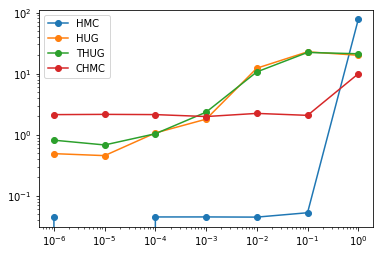

In [154]:
plot_values = plot_results(result6)

fig, ax = plt.subplots()
for alg in ['HMC', 'HUG', 'THUG', 'CHMC']:
    ax.plot(list(result6.keys()), plot_values[alg], marker='o', label=alg)
ax.set_xticklabels(['{}'.format(σ) for σ in list(result6.keys())])
ax.loglog()
ax.legend()
plt.show()

In [ ]:
# I should compute the minimum ESS over the θ variable only for C-HMC

In [45]:
# could always add a one second pause onto f computation just to make it more expensive? 